In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [19]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines1(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [22]:
def draw_lines1(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print('shape of lines: ', lines.shape)
    
    for line in lines:
        print('shape of line: ', line.shape)
        for x1,y1,x2,y2 in line:
            print(x1,y1,x2,y2)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
            

In [23]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    curated_lines = []
    
    # find average left slope
    # if circa insadie find lowert leftmost, and top rigth
    left_slope = []
    right_slope = []
    for line in lines:
#       print('shape of line: ', line.shape)
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
#            print('slope: ',slope)
            if slope < 0:
                left_slope.append(slope)                
            else:
                right_slope.append(slope)
        

    left_slope = np.average(left_slope)
    right_slope = np.average(right_slope)
#    print('left lanes', left_slope)
#    print('right lanes', right_slope)

    
    xr0 = 0
    yr0 = 0
    xr1 = 10000
    yr1 = 10000
    
    xl0 = 0
    yl0 = 10000
    xl1 = 10000
    yl1 = 0

    for line in lines:

        for x0,y0,x1,y1 in line:
            slope = ((y1-y0)/(x1-x0))
            if slope > 0: # right
                if np.abs(slope - right_slope) < 0.1:
                    xr0 = max(xr0,x0)
                    yr0 = max(yr0,y0)
                    yr1 = min(yr1,y1)
                    xr1 = min(xr1,x1)
            else:   #left
                if np.abs(slope - left_slope) < 0.1:
                    xl0 = max(xl0,x0)
                    yl0 = min(yl0,y1)
                    xl1 = min(xl1,x1)
                    yl1 = max(yl1,y1)
   
    #extrapolate all the way down y = 539
    
    if (yl0-yl1) != 0:
        ylstart = 539   
        xlstart = math.floor(((ylstart-yl0)*(xl0-xl1))/(yl0-yl1)) + xl0
        ylend = 319
        xlend = math.floor(((ylend-yl1)*(xl1-xl0))/(yl1-yl0)) + xl1
        slope = (ylend-ylstart)/(xlend-xlstart)
        if abs(slope-left_slope) > 0.5:
            print('Differnet slope on the left: ', [xlstart,ylstart,xlend,ylend],[slope,left_slope,slope-left_slope])
        else:
            if (110 > xlstart) or (xlstart > 250):
                print('left X out of position: (110-250)', [xlstart,ylstart,xlend,ylend],[slope,left_slope,slope-left_slope])
            else:
                curated_lines.append([[xlstart,ylstart,xlend,ylend]])
            

    if (yr0-yr1) != 0:
        yrstart = 319
        xrstart = math.floor(((yrstart-yr0)*(xr0-xr1))/(yr0-yr1)) + xr0
        yrend = 539
        xrend = math.floor(((yrend-yr1)*(xr1-xr0))/(yr1-yr0)) + xr1
        slope = (yrend-yrstart)/(xrend-xrstart)
        if abs(slope-right_slope) > 0.5:
            print('Differnet slope on the right: ', [xrstart,yrstart,xrend,yrend],[slope,right_slope,slope-right_slope])
        else:
            if (750 > xrend) or (xrend > 900):
                print('rigth X out of position: (750-900) ', [xrstart,yrstart,xrend,yrend],[slope,right_slope,slope-right_slope])
            else:
                curated_lines.append([[xrstart,yrstart,xrend,yrend]])
            


    
    curated_lines = np.array(curated_lines,dtype=int)
#    print('shape of lines: ', curated_lines.shape)
#    print(curated_lines)
    
    for line in curated_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            

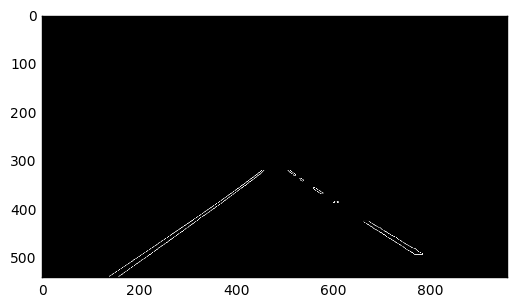

shape of lines:  (58, 1, 4)
shape of line:  (1, 4)
661 425 748 480
shape of line:  (1, 4)
323 414 347 396
shape of line:  (1, 4)
202 495 260 457
shape of line:  (1, 4)
365 391 406 359
shape of line:  (1, 4)
409 357 421 349
shape of line:  (1, 4)
559 357 575 368
shape of line:  (1, 4)
237 483 243 477
shape of line:  (1, 4)
774 493 784 493
shape of line:  (1, 4)
329 416 338 409
shape of line:  (1, 4)
263 454 277 445
shape of line:  (1, 4)
186 519 201 507
shape of line:  (1, 4)
356 391 445 326
shape of line:  (1, 4)
671 424 684 431
shape of line:  (1, 4)
313 427 325 419
shape of line:  (1, 4)
433 340 444 330
shape of line:  (1, 4)
220 494 231 487
shape of line:  (1, 4)
251 473 264 462
shape of line:  (1, 4)
282 442 299 429
shape of line:  (1, 4)
738 465 764 480
shape of line:  (1, 4)
343 406 349 402
shape of line:  (1, 4)
709 447 732 460
shape of line:  (1, 4)
307 425 312 420
shape of line:  (1, 4)
289 446 296 439
shape of line:  (1, 4)
159 525 172 515
shape of line:  (1, 4)
449 328 454 3

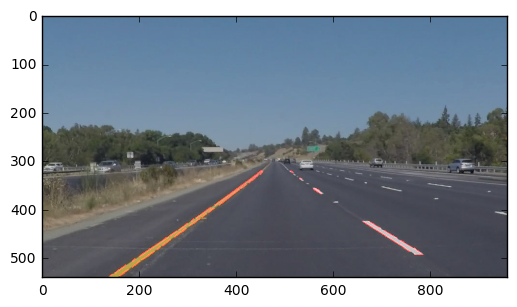

In [28]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')


image_gray = grayscale(image)

    # blur
    # Define a kernel size and apply Gaussian smoothing
kernel_size = 11
image_blur = gaussian_blur(image_gray,kernel_size)

    #canny edge detection
    # Define our parameters for Canny and run it (1,10)
low_threshold = 50
high_threshold = 200

image_canny = canny(image_blur,low_threshold,high_threshold)
    
    # find area of interest
left_bottom = [50, 539]
left_top = [450,320]
right_top = [530,320] 
right_bottom = [890, 539]
vertices = np.array([[(left_bottom[0],left_bottom[1]),(left_top[0], left_top[1] ), (right_top[0], right_top[1] ), (right_bottom[0],right_bottom[1])]], dtype=np.int32)
image_triangle = region_of_interest(image_canny,vertices)
plt.interactive(False)
plt.imshow(image_triangle,cmap='gray')
plt.show()

    # find lines

rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
    
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments

image_hough = hough_lines(image_triangle,rho,theta,threshold,min_line_length,max_line_gap)

image_result = weighted_img(image_hough,image)
plt.interactive(False)
plt.imshow(image_result)
plt.show()

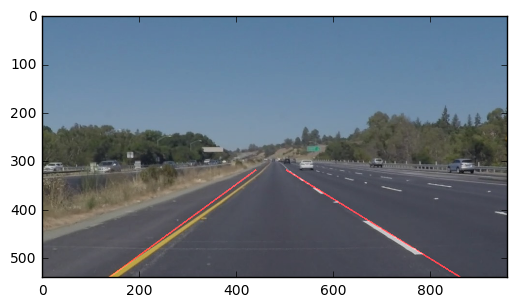

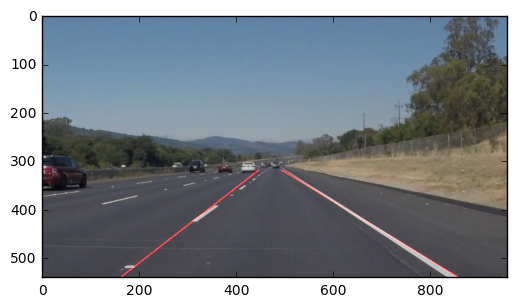

In [411]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_result = imagepipeline(image)
plt.interactive(False)
plt.imshow(image_result)
plt.show()



.DS_Store
solidWhiteCurve.jpg


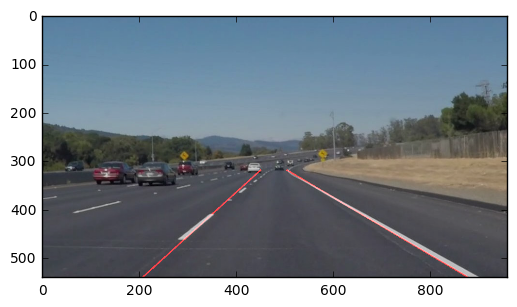

solidWhiteRight.jpg


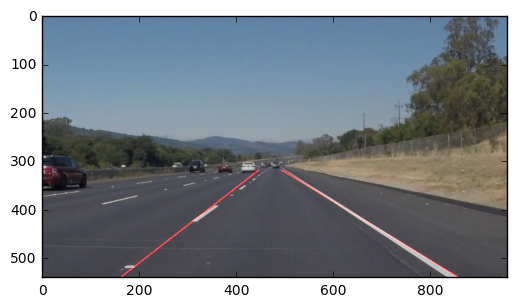

solidYellowCurve.jpg


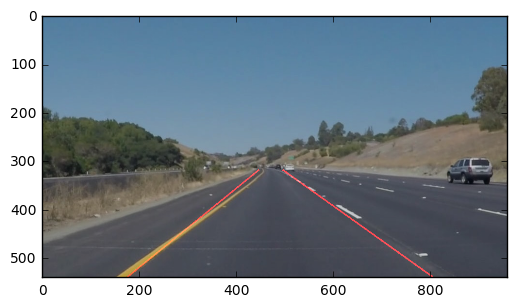

solidYellowCurve2.jpg


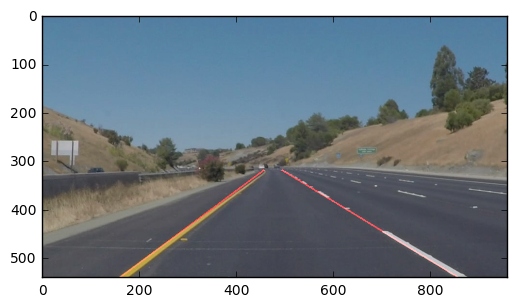

solidYellowLeft.jpg


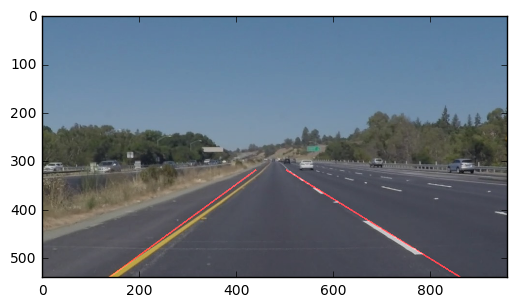

whiteCarLaneSwitch.jpg


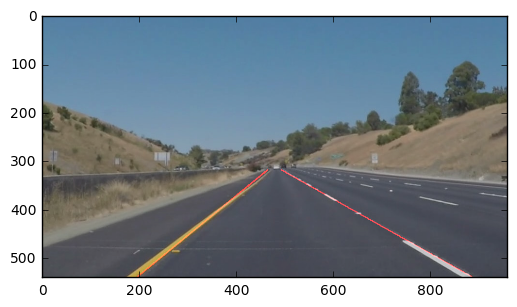

In [412]:


files = os.listdir("test_images/")

for i in files:
    print(i)
    if i != '.DS_Store':
        image = mpimg.imread('test_images/' + i)
        #printing out some stats and plotting
        #print('This image is:', type(image), 'with dimesions:', image.shape)
        

        image_result = imagepipeline(image)


        plt.interactive(False)

        plt.imshow(image_result)
        plt.show()



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [413]:
from imageio.plugins import ffmpeg
ffmpeg.download()

In [414]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [415]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    result = imagepipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [416]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


 18%|█▊        | 40/222 [00:00<00:03, 56.21it/s]

Differnet slope on the left:  [394, 539, 333, 319] [3.6065573770491803, -0.78786728767753433, 4.3944246647267144]


 38%|███▊      | 84/222 [00:01<00:03, 45.99it/s]WARNING:py.warnings:/Users/ktun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in int_scalars



 43%|████▎     | 96/222 [00:01<00:02, 49.20it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 59%|█████▉    | 132/222 [00:02<00:01, 51.66it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 81%|████████  | 179/222 [00:03<00:01, 41.21it/s]

Differnet slope on the left:  [412, 539, 368, 319] [5.0, -0.78856209150326795, 5.7885620915032678]


100%|█████████▉| 221/222 [00:04<00:00, 47.44it/s]


Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.22 s, sys: 1.37 s, total: 4.6 s
Wall time: 5.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [181]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [417]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



left X out of position: (110-250) [106, 539, 457, 319] [-0.62678062678062674, -0.6076621509788559, -0.01911847580177084]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 7/682 [00:00<00:10, 61.98it/s]WARNING:py.warnings:/Users/ktun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in int_scalars





left X out of position: (110-250) [106, 539, 457, 319] [-0.62678062678062674, -0.6076621509788559, -0.01911847580177084]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, 0.44176587301587306, 0.55823412698412689]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


  4%|▍         | 28/682 [00:00<00:10, 63.27it/s]

left X out of position: (110-250) [84, 539, 454, 319] [-0.59459459459459463, -0.67834945681099545, 0.083754862216400827]
rigth X out of position: (750-900)  [412, 319, 1072, 539] [0.33333333333333331, 0.47312271062271061, -0.13978937728937729]
rigth X out of position: (750-900)  [461, 319, 941, 539] [0.45833333333333331, 0.46758942811574383, -0.0092560947824105178]
rigth X out of position: (750-900)  [490, 319, 930, 539] [0.5, 0.43293650793650795, 0.067063492063492047]


  6%|▋         | 44/682 [00:00<00:09, 67.42it/s]

rigth X out of position: (750-900)  [508, 319, 1021, 539] [0.42884990253411304, 0.47401686033264984, -0.0451669577985368]
Differnet slope on the right:  [544, 319, 654, 539] [2.0, 0.43398660243053838, 1.5660133975694617]


  9%|▉         | 62/682 [00:01<00:13, 45.19it/s]

left X out of position: (110-250) [76, 539, 446, 319] [-0.59459459459459463, -0.81054178521283804, 0.21594719061824341]
rigth X out of position: (750-900)  [439, 319, 989, 539] [0.40000000000000002, 0.45563695563695561, -0.055636955636955587]


 11%|█         | 72/682 [00:01<00:15, 39.21it/s]

rigth X out of position: (750-900)  [463, 319, 976, 539] [0.42884990253411304, 0.38433361510284586, 0.044516287431267176]
rigth X out of position: (750-900)  [458, 319, 920, 539] [0.47619047619047616, 0.48704149080446657, -0.010851014613990406]


 12%|█▏        | 85/682 [00:01<00:19, 31.12it/s]

rigth X out of position: (750-900)  [465, 319, 941, 539] [0.46218487394957986, 0.40071428571428569, 0.061470588235294166]


 15%|█▍        | 102/682 [00:02<00:16, 35.05it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 16%|█▌        | 110/682 [00:02<00:18, 30.94it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [445, 319, 979, 539] [0.41198501872659177, 0.40436507936507937, 0.0076199393615123956]
rigth X out of position: (750-900)  [433, 319, 946, 539] [0.42884990253411304, 0.35566408899742236, 0.07318581353669068]


 19%|█▉        | 130/682 [00:03<00:16, 33.92it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 23%|██▎       | 154/682 [00:03<00:12, 41.70it/s]

rigth X out of position: (750-900)  [386, 319, 1046, 539] [0.33333333333333331, 0.41456571989487351, -0.081232386561540193]


 25%|██▌       | 172/682 [00:04<00:10, 49.38it/s]

rigth X out of position: (750-900)  [259, 319, 903, 539] [0.34161490683229812, 0.47305797055797061, -0.13144306372567249]


 28%|██▊       | 190/682 [00:04<00:09, 52.41it/s]

rigth X out of position: (750-900)  [493, 319, 904, 539] [0.53527980535279807, 0.35739171160223793, 0.17788809375056014]
rigth X out of position: (750-900)  [254, 319, 908, 539] [0.3363914373088685, 0.37525841951323718, -0.038866982204368683]


 30%|██▉       | 202/682 [00:04<00:09, 51.54it/s]

rigth X out of position: (750-900)  [463, 319, 1123, 539] [0.33333333333333331, 0.34829931972789113, -0.014965986394557818]


 31%|███▏      | 214/682 [00:04<00:09, 50.71it/s]

rigth X out of position: (750-900)  [444, 319, 1544, 539] [0.20000000000000001, 0.28588621255287916, -0.085886212552879149]


 35%|███▍      | 238/682 [00:05<00:09, 47.09it/s]

rigth X out of position: (750-900)  [460, 319, 1120, 539] [0.33333333333333331, 0.30358187134502923, 0.029751461988304084]


 36%|███▋      | 248/682 [00:05<00:09, 44.89it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 39%|███▊      | 264/682 [00:06<00:08, 48.32it/s]

rigth X out of position: (750-900)  [477, 319, 967, 539] [0.44897959183673469, 0.45451901040136333, -0.0055394185646286398]
Differnet slope on the right:  [506, 319, 286, 539] [-1.0, 0.40669075548107808, -1.4066907554810781]
rigth X out of position: (750-900)  [340, 319, 1088, 539] [0.29411764705882354, 0.43930534675456517, -0.14518769969574163]
rigth X out of position: (750-900)  [398, 319, 985, 539] [0.37478705281090291, 0.3745132645132645, 0.00027378829763841095]
left X out of position: (110-250) [108, 539, 446, 319] [-0.65088757396449703, -0.694866353400174, 0.043978779435676962]


 40%|████      | 276/682 [00:06<00:08, 49.94it/s]

rigth X out of position: (750-900)  [483, 319, 907, 539] [0.51886792452830188, 0.39708523099864351, 0.12178269352965837]


 42%|████▏     | 288/682 [00:06<00:07, 51.39it/s]

rigth X out of position: (750-900)  [476, 319, 916, 539] [0.5, 0.30189786059351276, 0.19810213940648724]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [241, 319, 1100, 539] [0.25611175785797441, 0.24101618867243865, 0.015095569185535757]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 47%|████▋     | 323/682 [00:07<00:07, 50.61it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 50%|█████     | 341/682 [00:07<00:06, 50.32it/s]

rigth X out of position: (750-900)  [480, 319, 939, 539] [0.47930283224400871, 0.46980839972138777, 0.0094944325226209436]


 51%|█████     | 347/682 [00:08<00:13, 25.27it/s]

rigth X out of position: (750-900)  [479, 319, 943, 539] [0.47413793103448276, 0.35313703390626466, 0.1210008971282181]
rigth X out of position: (750-900)  [333, 319, 995, 539] [0.33232628398791542, 0.43651891586674196, -0.10419263187882655]


 53%|█████▎    | 359/682 [00:08<00:12, 26.38it/s]

rigth X out of position: (750-900)  [477, 319, 908, 539] [0.51044083526682138, 0.42194425457583346, 0.088496580690987925]


 55%|█████▍    | 375/682 [00:09<00:10, 30.32it/s]

rigth X out of position: (750-900)  [477, 319, 933, 539] [0.48245614035087719, 0.44666397872280222, 0.03579216162807497]


 57%|█████▋    | 387/682 [00:09<00:08, 34.38it/s]

left X out of position: (110-250) [66, 539, 439, 319] [-0.58981233243967823, -0.77457057467068913, 0.18475824223101089]
rigth X out of position: (750-900)  [439, 319, 989, 539] [0.40000000000000002, 0.35607142857142854, 0.043928571428571483]


 58%|█████▊    | 396/682 [00:09<00:07, 37.22it/s]

left X out of position: (110-250) [70, 539, 450, 319] [-0.57894736842105265, -0.64351399852629743, 0.064566630105244771]


 59%|█████▉    | 404/682 [00:09<00:08, 31.36it/s]

left X out of position: (110-250) [91, 539, 455, 319] [-0.60439560439560436, -0.67466221088143541, 0.070266606485831051]


 61%|██████▏   | 418/682 [00:10<00:09, 28.97it/s]

left X out of position: (110-250) [69, 539, 453, 319] [-0.57291666666666663, -0.69960320353150263, 0.126686536864836]


 63%|██████▎   | 433/682 [00:10<00:07, 35.24it/s]

left X out of position: (110-250) [73, 539, 434, 319] [-0.60941828254847641, -0.76508122694020142, 0.15566294439172501]
rigth X out of position: (750-900)  [443, 319, 993, 539] [0.40000000000000002, 0.43460701484895037, -0.034607014848950346]


 66%|██████▌   | 451/682 [00:11<00:05, 44.91it/s]

left X out of position: (110-250) [75, 539, 448, 319] [-0.58981233243967823, -0.69967687066774975, 0.10986453822807152]
Differnet slope on the right:  [832, 319, 172, 539] [-0.33333333333333331, 0.46277888777888776, -0.79611222111222113]
Differnet slope on the left:  [153, 539, 336, 319] [-1.2021857923497268, -0.69275642618323852, -0.50942936616648826]
left X out of position: (110-250) [81, 539, 850, 319] [-0.28608582574772434, -0.65874543858191392, 0.37265961283418958]


 67%|██████▋   | 456/682 [00:11<00:05, 40.14it/s]

left X out of position: (110-250) [88, 539, 456, 319] [-0.59782608695652173, -0.67108930211202911, 0.073263215155507377]


 68%|██████▊   | 466/682 [00:11<00:05, 38.90it/s]

rigth X out of position: (750-900)  [476, 319, 1063, 539] [0.37478705281090291, 0.37202056277056278, 0.0027664900403401305]


 70%|██████▉   | 477/682 [00:11<00:04, 43.06it/s]

rigth X out of position: (750-900)  [489, 319, 903, 539] [0.53140096618357491, 0.39545385347815021, 0.1359471127054247]


 73%|███████▎  | 495/682 [00:12<00:08, 22.35it/s]

rigth X out of position: (750-900)  [492, 319, 910, 539] [0.52631578947368418, 0.46773145155498097, 0.058584337918703211]


 75%|███████▍  | 510/682 [00:13<00:05, 33.96it/s]

Differnet slope on the right:  [319, 319, 539, 539] [1.0, 0.38444187734940088, 0.61555812265059906]


 78%|███████▊  | 529/682 [00:13<00:03, 40.43it/s]

rigth X out of position: (750-900)  [458, 319, 1008, 539] [0.40000000000000002, 0.44669290948702711, -0.04669290948702709]
left X out of position: (110-250) [72, 539, 462, 319] [-0.5641025641025641, -0.6550601376775137, 0.090957573574949602]
Differnet slope on the right:  [556, 319, 729, 539] [1.2716763005780347, 0.44976325757575758, 0.82191304300227719]


 82%|████████▏ | 559/682 [00:14<00:04, 29.69it/s]

rigth X out of position: (750-900)  [414, 319, 1001, 539] [0.37478705281090291, 0.49902701465201466, -0.12423996184111175]
rigth X out of position: (750-900)  [298, 319, 961, 539] [0.33182503770739064, 0.5310386630081827, -0.19921362530079206]


 83%|████████▎ | 567/682 [00:14<00:03, 30.29it/s]

left X out of position: (110-250) [81, 539, 462, 319] [-0.57742782152230976, -0.79358657607828365, 0.21615875455597389]
rigth X out of position: (750-900)  [375, 319, 903, 539] [0.41666666666666669, 0.45117730472603351, -0.034510638059366827]
left X out of position: (110-250) [88, 539, 457, 319] [-0.59620596205962062, -0.79020446388155552, 0.1939985018219349]


 84%|████████▍ | 575/682 [00:15<00:03, 30.79it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 88%|████████▊ | 598/682 [00:15<00:02, 34.36it/s]

rigth X out of position: (750-900)  [487, 319, 1001, 539] [0.42801556420233461, 0.42779220779220778, 0.00022335641012682927]


 92%|█████████▏| 627/682 [00:16<00:01, 40.23it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 93%|█████████▎| 637/682 [00:16<00:01, 38.98it/s]

rigth X out of position: (750-900)  [488, 319, 901, 539] [0.53268765133171914, 0.46885817312505568, 0.063829478206663459]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 96%|█████████▋| 657/682 [00:17<00:00, 38.40it/s]

left X out of position: (110-250) [103, 539, 452, 319] [-0.63037249283667618, -0.84730224550798716, 0.21692975267131098]


100%|█████████▉| 681/682 [00:17<00:00, 38.66it/s]

left X out of position: (110-250) [77, 539, 465, 319] [-0.5670103092783505, -0.76851412389585094, 0.20150381461750044]
rigth X out of position: (750-900)  [489, 319, 918, 539] [0.51282051282051277, 0.44380892707960362, 0.069011585740909154]
rigth X out of position: (750-900)  [486, 319, 939, 539] [0.4856512141280353, 0.46019066483412824, 0.025460549293907064]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.6 s, sys: 4.58 s, total: 16.1 s
Wall time: 18.8 s


In [318]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [418]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



rigth X out of position: (750-900)  [270, 319, 945, 539] [0.32592592592592595, 0.17859122859122858, 0.14733469733469737]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]WARNING:py.warnings:/Users/ktun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in int_scalars



  1%|          | 3/251 [00:00<00:10, 24.11it/s]

rigth X out of position: (750-900)  [270, 319, 945, 539] [0.32592592592592595, 0.17859122859122858, 0.14733469733469737]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [99, 319, 1705, 539] [0.13698630136986301, 0.068223443223443217, 0.068762858146419789]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [176, 319, 1151, 539] [0.22564102564102564, 0.11394400352733688, 0.11169702211368876]
rigth X out of position: (750-900)  [120, 319, 1169, 539] [0.20972354623450906, 0.12346679301903185, 0.086256753215477211]
left X out of position: (110-250) [495, 539, 755, 319] [-0.84615384615384615, -0.52658647833970795, -0.31956736781413819]
rigth X out of position: (750-900)  [181, 319, 1083, 539] [0.24390243902439024, 0.10850660282478465, 0.1353958361996056]
Differnet slope on the right:  [282, 319, 588, 539] [0.71895424836601307, 0.094849926193209783, 0.62410432217280332]


  4%|▍         | 11/251 [00:00<00:08, 28.98it/s]

left X out of position: (110-250) [65, 539, 828, 319] [-0.28833551769331583, -0.52599512919502023, 0.23765961150170439]
rigth X out of position: (750-900)  [336, 319, 948, 539] [0.35947712418300654, 0.25229041756958009, 0.10718670661342644]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [184, 319, 958, 539] [0.2842377260981912, 0.1794774859843353, 0.1047602401138559]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [277, 319, 922, 539] [0.34108527131782945, 0.12107147902602451, 0.22001379229180495]
rigth X out of position: (750-900)  [141, 319, 943, 539] [0.27431421446384041, 0.091636682221097818, 0.18267753224274258]
rigth X out of position: (750-900)  [-4442, 319, 5733, 539] [0.021621621621621623, 0.05361772486772487, -0.031996103246103247]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0


  6%|▌         | 15/251 [00:00<00:07, 29.80it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
rigth X out of position: (750-900)  [249, 319, 966, 539] [0.30683403068340309, 0.2292830842538445, 0.077550946429558593]
rigth X out of position: (750-900)  [282, 319, 950, 539] [0.32934131736526945, 0.21159488659488654, 0.11774643077038291]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [167, 319, 636, 539] [0.46908315565031983, 0.11515666872809729, 0.35392648692222251]


  8%|▊         | 19/251 [00:00<00:07, 30.38it/s]

rigth X out of position: (750-900)  [107, 319, 1133, 539] [0.21442495126705652, 0.17788658049152803, 0.036538370775528489]
rigth X out of position: (750-900)  [230, 319, 1090, 539] [0.2558139534883721, 0.17964425977338461, 0.076169693714987496]


  9%|▉         | 23/251 [00:00<00:07, 31.05it/s]

rigth X out of position: (750-900)  [190, 319, 1272, 539] [0.20332717190388169, 0.065160533910533905, 0.13816663799334777]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [225, 319, 1021, 539] [0.27638190954773867, 0.12050498300498302, 0.15587692654275564]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [195, 319, 635, 539] [0.5, 0.27303287981859414, 0.22696712018140586]


 10%|█         | 26/251 [00:00<00:07, 30.72it/s]

left X out of position: (110-250) [264, 539, 722, 319] [-0.48034934497816595, -0.469766493675985, -0.010582851302180951]
rigth X out of position: (750-900)  [92, 319, 1157, 539] [0.20657276995305165, 0.23280232639988735, -0.026229556446835695]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 12%|█▏        | 29/251 [00:00<00:08, 26.73it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [195, 319, 1134, 539] [0.23429179978700745, 0.18884779213656219, 0.045444007650445262]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [226, 319, 1015, 539] [0.27883396704689478, 0.23138308168795974, 0.047450885358935047]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [70, 319, 1097, 539] [0.21421616358325218, 0.18893324929039215, 0.025282914292860031]
rigth X out of position: (750-900)  [193, 319, 952, 539] [0.28985507246376813, 0.18004396397253539, 0.10981110849123274]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 14%|█▍        | 35/251 [00:01<00:08, 26.46it/s]

rigth X out of position: (750-900)  [-40, 319, 1280, 539] [0.16666666666666666, 0.22716392030908156, -0.0604972536424149]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [241, 319, 911, 539] [0.32835820895522388, 0.19424036281179136, 0.13411784614343253]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
left X out of position: (110-250) [270, 539, 838, 319] [-0.38732394366197181, -0.46079015491609487, 0.073466211254123059]
rigth X out of position: (750-900)  [223, 319, 920, 539] [0.31563845050215206, 0.2361167800453515, 0.079521670456800558]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-8, 319, 1230, 539] [0.17770597738287561, 0.17649057598748003, 0.0012154013953955822]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 16%|█▋        | 41/251 [00:01<00:08, 25.80it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [189, 319, 1061, 539] [0.25229357798165136, 0.24885714285714286, 0.0034364351245085023]
left X out of position: (110-250) [484, 539, 820, 319] [-0.65476190476190477, -0.52132234991680126, -0.1334395548451035]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 19%|█▊        | 47/251 [00:01<00:08, 23.93it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [364, 319, 922, 539] [0.3942652329749104, 0.27830960705960706, 0.11595562591530334]
left X out of position: (110-250) [469, 539, 864, 319] [-0.55696202531645567, -0.51551073669659186, -0.041451288619863802]
rigth X out of position: (750-900)  [166, 319, 956, 539] [0.27848101265822783, 0.28034434203789049, -0.0018633293796626593]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
left X out of position: (110-250) [265, 539, 1189, 319] [-0.23809523809523808, -0.65190330331799184, 0.41380806522275376]


 21%|██        | 53/251 [00:01<00:08, 23.59it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [338, 319, 966, 539] [0.3503184713375796, 0.29938992090890826, 0.050928550428671338]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 24%|██▎       | 59/251 [00:02<00:08, 22.18it/s]

left X out of position: (110-250) [476, 539, 825, 319] [-0.63037249283667618, -0.84779406171662064, 0.21742156887994446]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [195, 319, 950, 539] [0.29139072847682118, 0.20971988795518204, 0.081670840521639143]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [144, 319, 1005, 539] [0.25551684088269455, 0.23383928571428569, 0.021677555168408857]


 25%|██▍       | 62/251 [00:02<00:08, 22.10it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [268, 319, 1013, 539] [0.29530201342281881, 0.2953279866201215, -2.5973197302686657e-05]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [119, 319, 1159, 539] [0.21153846153846154, 0.20234725070251386, 0.0091912108359476774]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 27%|██▋       | 68/251 [00:02<00:08, 22.50it/s]

Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 29%|██▉       | 74/251 [00:02<00:08, 20.41it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 31%|███       | 77/251 [00:03<00:10, 17.38it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 33%|███▎      | 83/251 [00:03<00:08, 20.54it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [151, 319, 602, 539] [0.48780487804878048, 0.19576479076479078, 0.29204008728398967]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [219, 319, 704, 539] [0.45360824742268041, 0.2899321556579621, 0.16367609176471831]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [232, 319, 705, 539] [0.46511627906976744, 0.27670709793351306, 0.18840918113625438]


 35%|███▌      | 89/251 [00:03<00:07, 22.88it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [71, 319, 709, 539] [0.34482758620689657, 0.081144875090187585, 0.26368271111670899]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-93, 319, 911, 539] [0.21912350597609562, 0.14240683229813667, 0.076716673677958952]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 37%|███▋      | 92/251 [00:03<00:07, 20.19it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 39%|███▉      | 98/251 [00:04<00:06, 22.74it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-278, 319, 730, 539] [0.21825396825396826, 0.026639968013207452, 0.19161400024076081]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
left X out of position: (110-250) [91, 539, 795, 319] [-0.3125, -0.36277667230112881, 0.050276672301128811]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 41%|████▏     | 104/251 [00:04<00:06, 23.34it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 43%|████▎     | 107/251 [00:04<00:06, 21.96it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-469, 319, 1196, 539] [0.13213213213213212, 0.20924796747967481, -0.077115835347542683]


 45%|████▌     | 113/251 [00:04<00:05, 23.89it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-302, 319, 1018, 539] [0.16666666666666666, 0.097510403033658835, 0.069156263633007822]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
left X out of position: (110-250) [253, 539, 820, 319] [-0.38800705467372132, -0.39912908226400301, 0.011122027590281691]
rigth X out of position: (750-900)  [-135, 319, 1445, 539] [0.13924050632911392, 0.098995399441828003, 0.040245106887285914]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-1095, 319, 1600, 539] [0.081632653061224483, 0.2221953967487526, -0.14056274368752814]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 46%|████▌     | 116/251 [00:04<00:06, 22.24it/s]

rigth X out of position: (750-900)  [-12, 319, 926, 539] [0.23454157782515991, 0.09969723402385941, 0.1348443438013005]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 47%|████▋     | 119/251 [00:05<00:07, 18.00it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-209, 319, 1344, 539] [0.14166130070830651, 0.12971004689754689, 0.011951253810759621]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-2483, 319, 2783, 539] [0.041777440182301555, 0.091430444555444565, -0.04965300437314301]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 49%|████▉     | 124/251 [00:05<00:06, 18.40it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
left X out of position: (110-250) [278, 539, 560, 319] [-0.78014184397163122, -0.43387470422229785, -0.34626713974933337]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [4, 319, 1071, 539] [0.20618556701030927, 0.25849183322587577, -0.052306266215566499]


 51%|█████▏    | 129/251 [00:05<00:06, 18.61it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 53%|█████▎    | 134/251 [00:05<00:07, 16.27it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 55%|█████▌    | 139/251 [00:06<00:06, 18.01it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [485, 319, 840, 539] [0.61971830985915488, 0.1094366635543106, 0.51028164630484429]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-2384, 319, 1741, 539] [0.053333333333333337, 0.043871954918466551, 0.0094613784148667862]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-876, 319, 960, 539] [0.11982570806100218, 0.25924511995940569, -0.13941941189840351]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 57%|█████▋    | 143/251 [00:06<00:05, 18.16it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [359, 319, 747, 539] [0.5670103092783505, 0.085660173160173159, 0.48135013611817734]


 59%|█████▉    | 148/251 [00:06<00:05, 18.29it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [316, 319, 660, 539] [0.63953488372093026, 0.075193083431719793, 0.56434180028921044]
Differnet slope on the right:  [361, 319, 597, 539] [0.93220338983050843, 0.047203850676072898, 0.88499953915443552]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [184, 319, 993, 539] [0.27194066749072932, 0.066628903742305803, 0.20531176374842353]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [271, 319, 974, 539] [0.31294452347083929, 0.042042174996720451, 0.27090234847411881]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [406, 319, 600, 539] [1.134020618556701, 0.093494030551552684, 1.0405265880051484]


 61%|██████▏   | 154/251 [00:06<00:04, 21.00it/s]

left X out of position: (110-250) [462, 539, 884, 319] [-0.52132701421800953, -0.45304025638822376, -0.068286757829785771]
rigth X out of position: (750-900)  [183, 319, 937, 539] [0.29177718832891247, 0.059678546470999301, 0.23209864185791318]
Differnet slope on the left:  [507, 539, 595, 319] [-2.5, -0.45872105741558089, -2.0412789425844191]
Differnet slope on the right:  [451, 319, 507, 539] [3.9285714285714284, 0.049195804717421257, 3.8793756238540071]
left X out of position: (110-250) [287, 539, 825, 319] [-0.40892193308550184, -0.42764461699555034, 0.018722683910048499]
Differnet slope on the right:  [390, 319, 650, 539] [0.84615384615384615, 0.11004237137893132, 0.73611147477491479]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [487, 319, 662, 539] [1.2571428571428571, 0.096465201465201461, 1.1606776556776557]
left X out of position: (110-250) [478, 539, 768, 319] [-0.75862068965517238, -0.4392894880595109, -0.3193312015956

 63%|██████▎   | 157/251 [00:07<00:04, 19.87it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the right:  [326, 319, 476, 539] [1.4666666666666666, 0.061667601945379721, 1.4049990647212869]
left X out of position: (110-250) [352, 539, 831, 319] [-0.45929018789144049, -0.48801102926753381, 0.02872084137609332]
Differnet slope on the right:  [280, 319, 517, 539] [0.92827004219409281, 0.081824096955675912, 0.84644594523841687]


 65%|██████▍   | 163/251 [00:07<00:03, 22.17it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-277, 319, 933, 539] [0.18181818181818182, 0.08552043194900337, 0.096297749869178453]
Differnet slope on the right:  [424, 319, 623, 539] [1.1055276381909547, 0.10961671509616715, 0.99591092309478757]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [374, 319, 599, 539] [0.97777777777777775, 0.11347505668934239, 0.86430272108843531]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]


 67%|██████▋   | 169/251 [00:07<00:03, 22.20it/s]

Differnet slope on the left:  [462, 539, 666, 319] [-1.0784313725490196, -0.44944231819988989, -0.62898905434912966]
Differnet slope on the right:  [454, 319, 595, 539] [1.5602836879432624, 0.072949179671868758, 1.4873345082713936]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 69%|██████▊   | 172/251 [00:07<00:04, 19.72it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
left X out of position: (110-250) [391, 539, 696, 319] [-0.72131147540983609, -0.44120880022871856, -0.28010267518111753]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [423, 319, 743, 539] [0.6875, 0.12130532865826982, 0.56619467134173018]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-301, 319, 1239, 539] [0.14285714285714285, 0.12186698332531666, 0.020990159531826189]


 71%|███████   | 178/251 [00:08<00:03, 21.24it/s]

Differnet slope on the right:  [616, 319, 506, 539] [-2.0, 0.086482570661069638, -2.0864825706610697]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [441, 319, 658, 539] [1.0138248847926268, 0.07137276785714286, 0.94245211693548392]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [115, 319, 913, 539] [0.27568922305764409, 0.07273478835978836, 0.20295443469785573]


 72%|███████▏  | 181/251 [00:08<00:03, 19.82it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [461, 319, 907, 539] [0.49327354260089684, 0.21251358991085018, 0.28075995269004667]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [462, 319, 717, 539] [0.86274509803921573, 0.091352813852813852, 0.77139228418640182]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-284, 319, 1118, 539] [0.15691868758915833, 0.086615266453976145, 0.07030342113518219]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [313, 319, 2953, 539] [0.083333333333333329, 0.087754349176762989, -0.0044210158434296598]


 75%|███████▍  | 187/251 [00:08<00:02, 21.75it/s]

rigth X out of position: (750-900)  [380, 319, 912, 539] [0.41353383458646614, 0.15285285285285286, 0.26068098173361332]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [484, 319, 833, 539] [0.63037249283667618, 0.11610728628800919, 0.51426520654866703]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-514, 319, 1445, 539] [0.11230219499744767, 0.152615690636524, -0.040313495639076324]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [379, 319, 1919, 539] [0.14285714285714285, 0.13233562242101141, 0.010521520436131443]
left X out of position: (110-250) [72, 539, 1085, 319] [-0.21717670286278382, -0.51473092263456055, 0.29755421977177676]


 76%|███████▌  | 190/251 [00:08<00:03, 20.10it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-381, 319, 1159, 539] [0.14285714285714285, 0.10406107179713991, 0.038796071060002935]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-48, 319, 1004, 539] [0.20912547528517111, 0.029299928926794599, 0.17982554635837653]


 78%|███████▊  | 196/251 [00:09<00:02, 19.82it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [64, 319, 916, 539] [0.25821596244131456, 0.10708107843657716, 0.1511348840047374]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-41, 319, 995, 539] [0.21235521235521235, 0.16207482993197278, 0.050280382423239567]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [362, 319, 296, 539] [-3.3333333333333335, 0.10520281184089582, -3.4385361451742291]


 79%|███████▉  | 199/251 [00:09<00:02, 19.58it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [374, 319, 918, 539] [0.40441176470588236, 0.21150130506748158, 0.19291045963840078]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-1117, 319, 2742, 539] [0.057009587976159626, 0.12203373015873016, -0.065024142182570535]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [15, 319, 1198, 539] [0.18596787827557057, 0.15915332764647833, 0.026814550629092243]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 82%|████████▏ | 205/251 [00:09<00:02, 19.35it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-173, 319, 1125, 539] [0.16949152542372881, 0.080820568320568303, 0.088670957103160503]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-478, 319, 1282, 539] [0.125, 0.068262186531417302, 0.056737813468582698]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [542, 319, 603, 539] [3.6065573770491803, 0.11580308580308579, 3.4907542912460947]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [86, 319, 1186, 539] [0.20000000000000001, 0.13096846846846844, 0.069031531531531576]


 84%|████████▍ | 211/251 [00:09<00:01, 22.24it/s]

rigth X out of position: (750-900)  [-1866, 319, 3139, 539] [0.043956043956043959, 0.28338420838420841, -0.23942816442816445]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [167, 319, 1179, 539] [0.21739130434782608, 0.12822224616342265, 0.089169058184403432]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-816, 319, 1866, 539] [0.082028337061894108, 0.13617665262050288, -0.054148315558608773]
rigth X out of position: (750-900)  [445, 319, 1149, 539] [0.3125, 0.13517967372134038, 0.17732032627865962]


 85%|████████▌ | 214/251 [00:09<00:01, 22.73it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-901, 319, 1959, 539] [0.076923076923076927, 0.055003126954346469, 0.021919949968730458]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-784, 319, 1196, 539] [0.1111111111111111, 0.12569588221762135, -0.014584771106510241]
rigth X out of position: (750-900)  [-388, 319, 932, 539] [0.16666666666666666, 0.094720715931242247, 0.07194595073542441]
rigth X out of position: (750-900)  [-1049, 319, 1591, 539] [0.083333333333333329, 0.053203463203463211, 0.030129870129870118]


 86%|████████▋ | 217/251 [00:10<00:01, 20.20it/s]

rigth X out of position: (750-900)  [-644, 319, 1776, 539] [0.090909090909090912, 0.11330559112249253, -0.022396500213401616]
rigth X out of position: (750-900)  [47, 319, 1177, 539] [0.19469026548672566, 0.15415417915417914, 0.040536086332546517]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-80, 319, 705, 539] [0.28025477707006369, 0.13914141414141415, 0.14111336292864954]
rigth X out of position: (750-900)  [-1066, 319, 1979, 539] [0.072249589490968796, 0.15037825226244345, -0.07812866277147465]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [540, 319, 711, 539] [1.2865497076023391, 0.10981688485558452, 1.1767328227467546]


 90%|█████████ | 226/251 [00:10<00:01, 23.59it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-26, 319, 1514, 539] [0.14285714285714285, 0.10853298017546242, 0.034324162681680426]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, 0.085161822304679446, 0.9148381776953205]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-385, 319, 1242, 539] [0.13521819299323909, 0.10859631821170282, 0.02662187478153627]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-1216, 319, 1557, 539] [0.079336458708979443, 0.23082577799558932, -0.15148931928660986]
rigth X out of position: (750-900)  [-145, 319, 1444, 539] [0.13845185651353054, 0.26038850038850037, -0.12193664387496983]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


 92%|█████████▏| 232/251 [00:10<00:00, 25.34it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-429, 319, 2211, 539] [0.083333333333333329, 0.083407798625189919, -7.4465291856590232e-05]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [76, 319, 924, 539] [0.25943396226415094, 0.223468660968661, 0.035965301295489943]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [410, 319, 1510, 539] [0.20000000000000001, 0.28927135031254031, -0.089271350312540299]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [525, 319, 854, 539] [0.66869300911854102, 0.095954723300261058, 0.5727382858182799]


 94%|█████████▎| 235/251 [00:10<00:00, 25.49it/s]

rigth X out of position: (750-900)  [69, 319, 987, 539] [0.23965141612200436, 0.13214285714285712, 0.10750855897914724]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-546, 319, 1214, 539] [0.125, 0.091670612373737373, 0.033329387626262627]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [256, 319, 1047, 539] [0.2781289506953224, 0.1424187637904723, 0.13571018690485009]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [257, 319, 1041, 539] [0.28061224489795916, 0.17160023884161815, 0.10901200605634101]


 96%|█████████▌| 241/251 [00:11<00:00, 21.77it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-1147, 319, 2219, 539] [0.06535947712418301, 0.11845572662104921, -0.053096249496866199]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [319, 319, 539, 539] [1.0, inf, -inf]
rigth X out of position: (750-900)  [417, 319, 905, 539] [0.45081967213114754, 0.12016879516879518, 0.33065087696235235]


 98%|█████████▊| 247/251 [00:11<00:00, 22.61it/s]

Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
rigth X out of position: (750-900)  [-568, 319, 1412, 539] [0.1111111111111111, 0.091602474323062566, 0.019508636788048539]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]


100%|██████████| 251/251 [00:11<00:00, 21.89it/s]


Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [527, 319, 585, 539] [3.7931034482758621, 0.16944091622663052, 3.6236625320492317]
Differnet slope on the left:  [9461, 539, 9681, 319] [-1.0, -inf, inf]
Differnet slope on the right:  [508, 319, 772, 539] [0.83333333333333337, 0.17342300556586271, 0.65991032776747072]
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.55 s, sys: 2.27 s, total: 9.82 s
Wall time: 13.1 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))